# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
import datetime

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv', parse_dates=True, index_col='Time')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.shape

(144, 2)

In [4]:
cigData.head()

,Unnamed: 0,#CigSales
Time,,
1949-01-01,0,1000112
1949-02-01,1,1000118
1949-03-01,2,1000132
1949-04-01,3,1000129
1949-05-01,4,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Unnamed: 0', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0    int64
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isnull().sum()

Unnamed: 0    0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData = cigData.drop('Unnamed: 0', axis=1)
cigData.head()

,#CigSales
Time,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [17]:
# Now let's Give Column[0] a new lablel name: Month
cigData.rename(columns = {list(cigData)[0]: 'CigSales'}, inplace = True)
cigData.index.names = ['Month']


Call a head() to check this has worked. 

In [18]:
cigData.head()

,CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [19]:
cigData.tail()

,CigSales
Month,
1960-08-01,1000606
1960-09-01,1000508
1960-10-01,1000461
1960-11-01,1000390
1960-12-01,1000432


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [20]:
#Alreadt done in dataset

Perfect! 

In [21]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [22]:
#let's reset the index so we can save the dataframe to analyze the data using Tableau!!!
df = cigData.reset_index()
df.head()

,Month,CigSales
0,1949-01-01,1000112
1,1949-02-01,1000118
2,1949-03-01,1000132
3,1949-04-01,1000129
4,1949-05-01,1000121


### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [24]:
 y = cigData.CigSales

Check the type of our new variable. 

In [25]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [26]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

Text(0, 0.5, 'Cigarettes Sales')

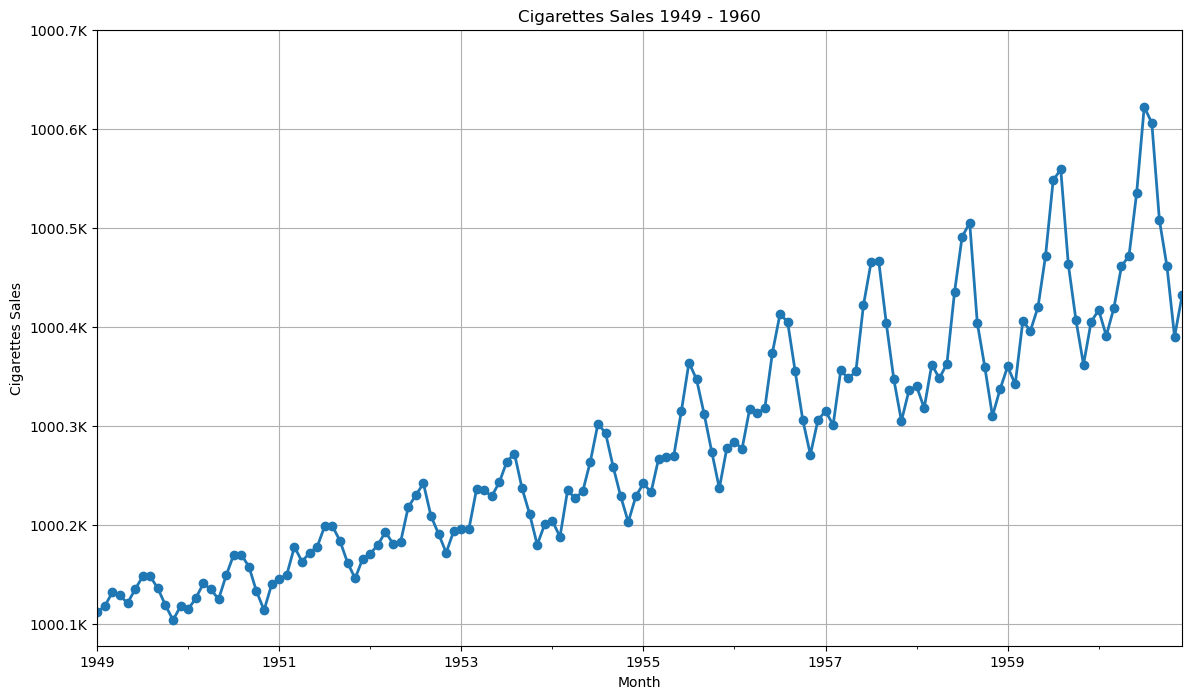

In [27]:
plt.figure(figsize=(14,8))
y.plot(marker='o', linewidth=2)
plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          ['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
#plt.ylim([1000100, 1000700])
plt.grid(True)
plt.title('Cigarettes Sales 1949 - 1960')
plt.ylabel('Cigarettes Sales')

### Cowboy Cigarettes Sales Summary:

 . We can see that, generally, there is a trend upwards in cigarette sales from Cowboy Cigarettes.
 .  Cigarette sales are always higher in Q3 of every year compared to other quarters between 1949-1960.
 . Cigarette sales are always higher in the Months of July and August of every year compared to other Months between 1949-1960.

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

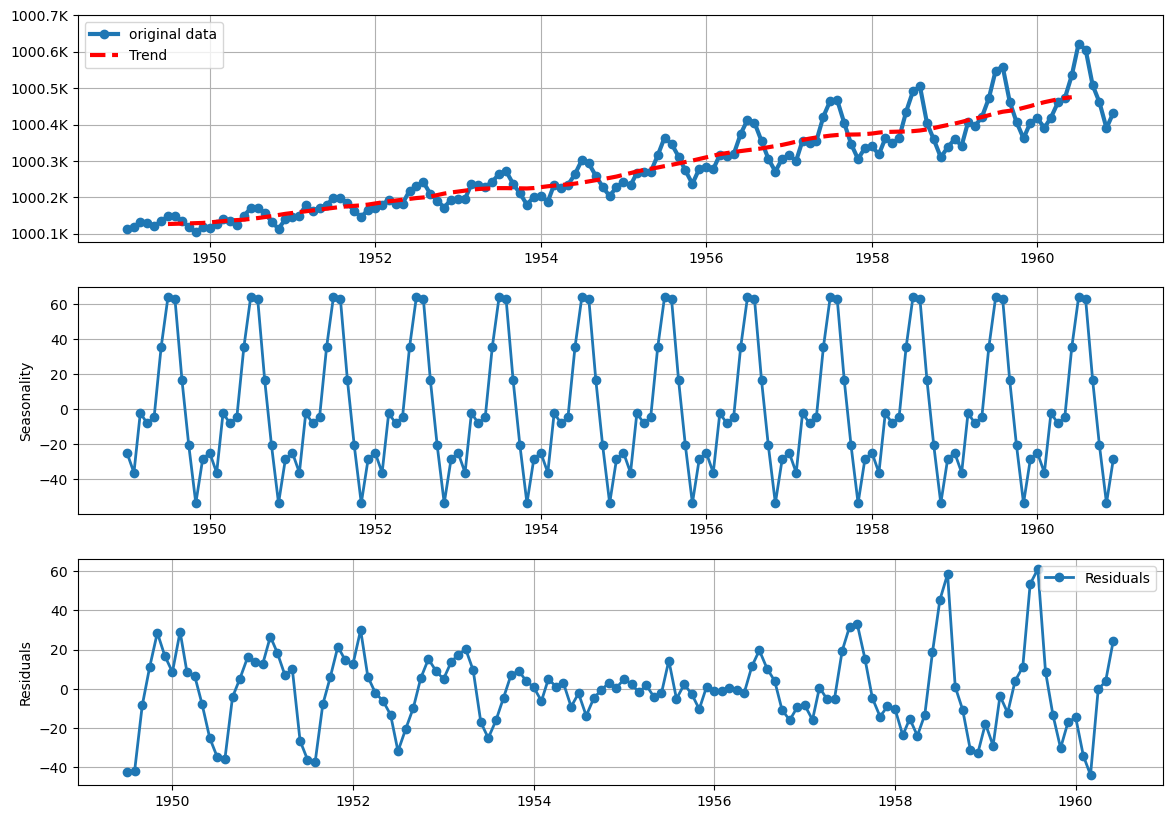

In [28]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y)#default Model is 'additive', so we need to make sure we use 'multiplicative'

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(y, label = 'original data', marker='o', linewidth=3)
plt.legend(loc = 'best')
plt.grid(True)
plt.plot(trend, label = 'Trend', color='r', linewidth=3, linestyle='dashed')
plt.legend(loc = 'best')
plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          ['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(seasonal, label = 'seasonality', marker='o', linewidth=2)
#plt.legend(loc = 'lower left')
plt.ylabel('Seasonality')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(residual, label = 'Residuals', marker='o', linewidth=2)
plt.legend(loc = 'best')
plt.ylabel('Residuals')
plt.grid(True)
#plt.tight_layout()

#### Seasonal_decompose Drawback:

 - From Trend chart above, Trend is missing the first and the last 6 months of the data - This is worth of one year of data.
 - From Seasonality chart above, the seasonality pattern is assumed to repeat every year

#### Decomposition: STL

Now let's try STL (Seasonal and Trend decomposition using Loess), which supposed to help in the above drawbacks:

<Figure size 1400x1000 with 0 Axes>

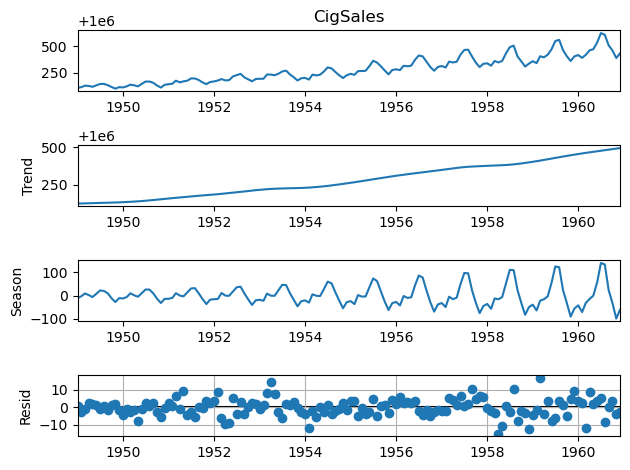

In [29]:
from statsmodels.tsa.seasonal import STL
plt.figure(figsize=(14,10))
res = STL(y).fit()
res.plot()
plt.grid(True)
plt.rc('figure',figsize=(12,10))
plt.rc('font',size=13)
plt.rc('lines', lw=2)
plt.rc('grid', c ='0.3', ls ='-', lw = 0.5) 
plt.show()

#### STL vs seasonal_decompose:

 - In STL, Trend chart reflects all the data without any missing (seasonal_decompose shows missing of one year of data).
 * Seasonality in STL refelects the Trends where in seasonal_decompose is assumed to be repeated year over year.

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [30]:
from statsmodels.tsa.stattools import kpss
print('*******Results of kpss Test*******')
kpsstest = kpss(y)
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)  
print('**********************************')

*******Results of kpss Test*******
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
**********************************


C:\Users\khara\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

Text(0, 0.5, 'Cigarettes Sales')

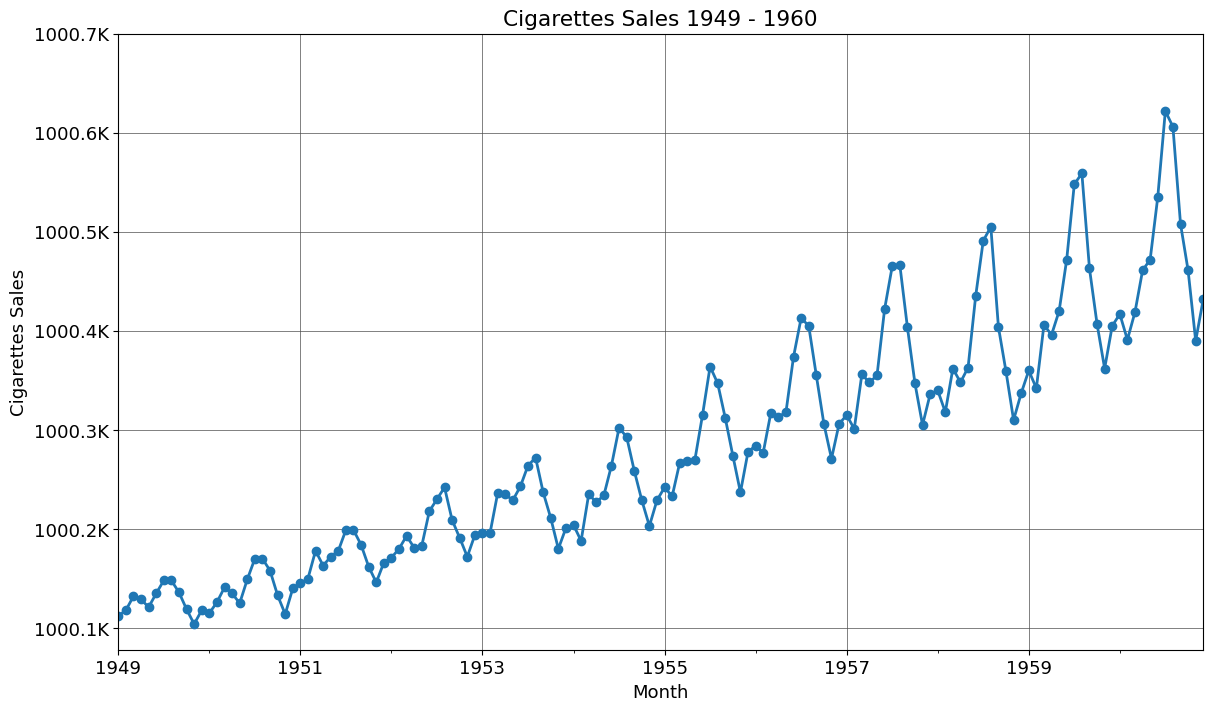

In [31]:
plt.figure(figsize=(14,8))
y.plot(marker='o', linewidth=2)
plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          ['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
#plt.ylim([1000100, 1000700])
plt.grid(True)
plt.title('Cigarettes Sales 1949 - 1960')
plt.ylabel('Cigarettes Sales')

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [32]:
# Declare a variable called y_log
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

Text(0.5, 1.0, 'Cigarettes Sales - log')

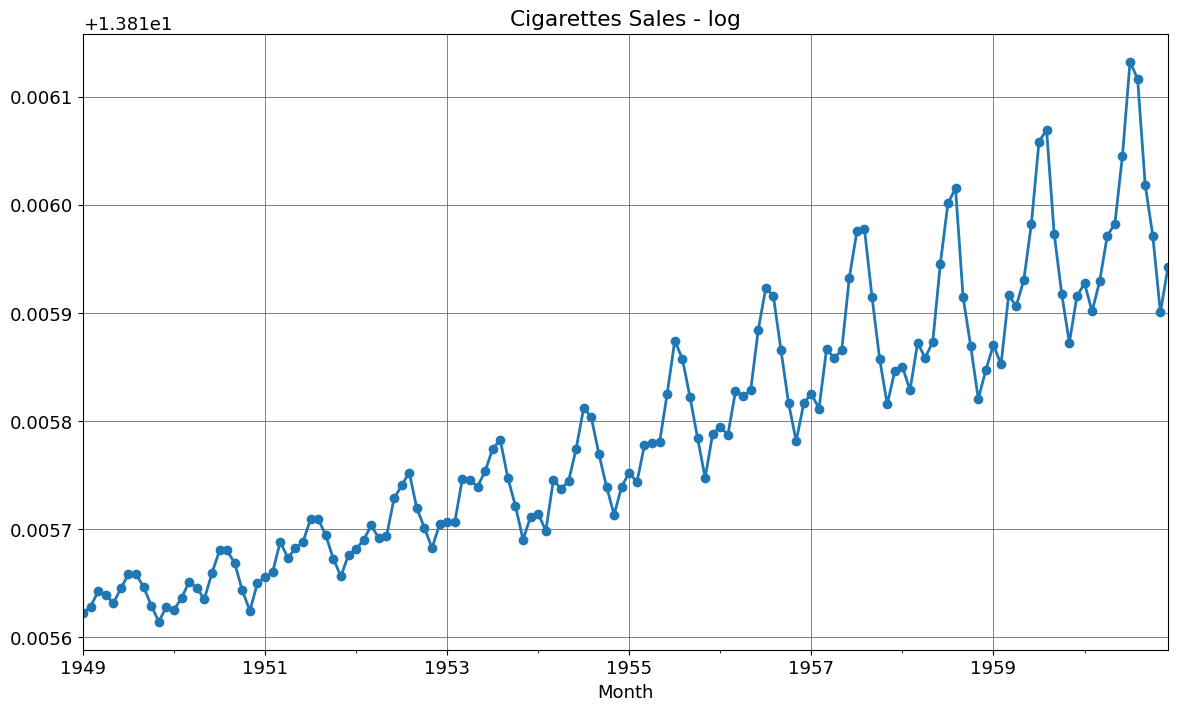

In [33]:
plt.figure(figsize=(14,8))
y_log.plot(marker='o', linewidth=2)
#plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          #['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
#plt.ylim([1000100, 1000700])
plt.grid(True)
plt.title('Cigarettes Sales - log')

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

Text(0.5, 1.0, 'Cigarettes Sales - log/diff')

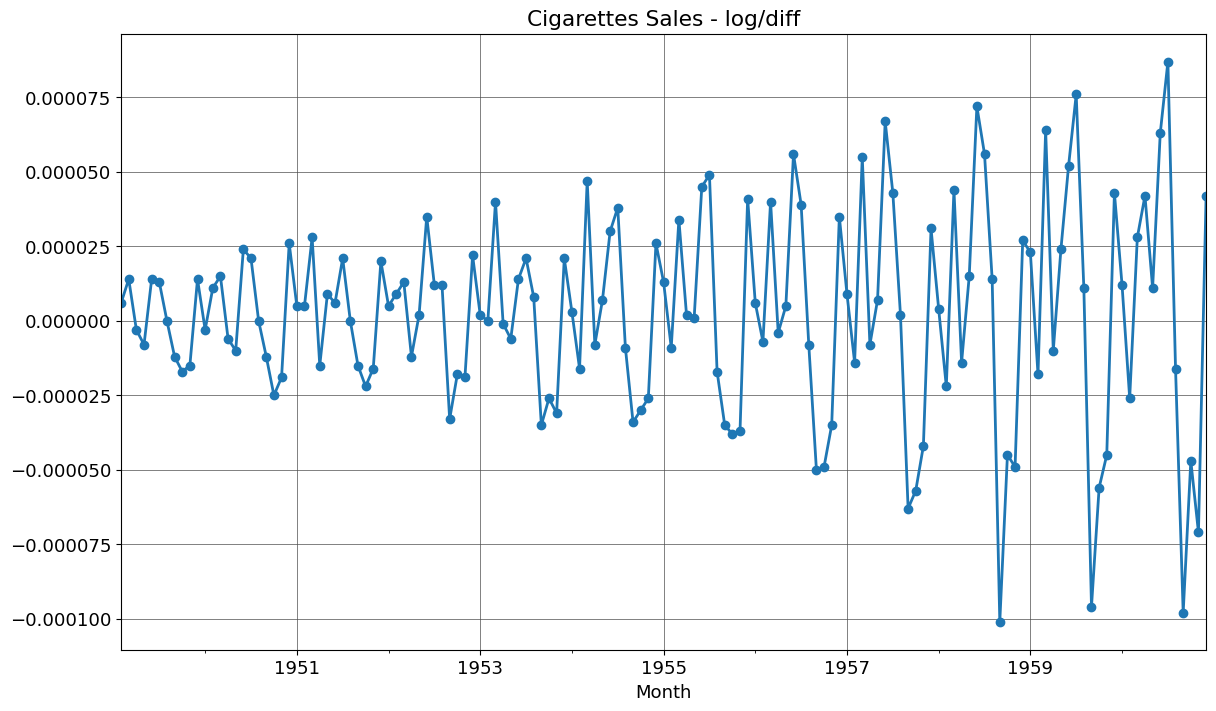

In [34]:
y_log_diff = y_log.diff()
y_log_diff = y_log_diff.dropna()


plt.figure(figsize=(14,8))
y_log_diff.plot(marker='o', linewidth=2)
#plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          #['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
#plt.ylim([1000100, 1000700])
plt.grid(True)
plt.title('Cigarettes Sales - log/diff')

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [35]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [36]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = sm.tsa.arima.ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [37]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.11f' % (order,mse)) # .3f changed to 11f to show the details of MSE
                except:
                    continue
    return print('Best ARIMA%s MSE=%.11f' % (best_cfg, best_score))# .3f changed to 11f to show the details of MSE

In [38]:
# Now, we choose a couple of values to try for each parameter.
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [39]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

Best ARIMANone MSE=inf


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [40]:
p = 2
d = 1
q = 1
model =sm.tsa.arima.ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [41]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1285.631
Date:                Sun, 02 Jun 2024   AIC                          -2563.263
Time:                        10:34:50   BIC                          -2551.411
Sample:                    01-01-1949   HQIC                         -2558.447
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575    1.1e-19   9.59e+18      0.000       1.057       1.057
ar.L2         -0.4391   6.75e-19  -6.51e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.02e-20  -2.35e+19      0.0

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

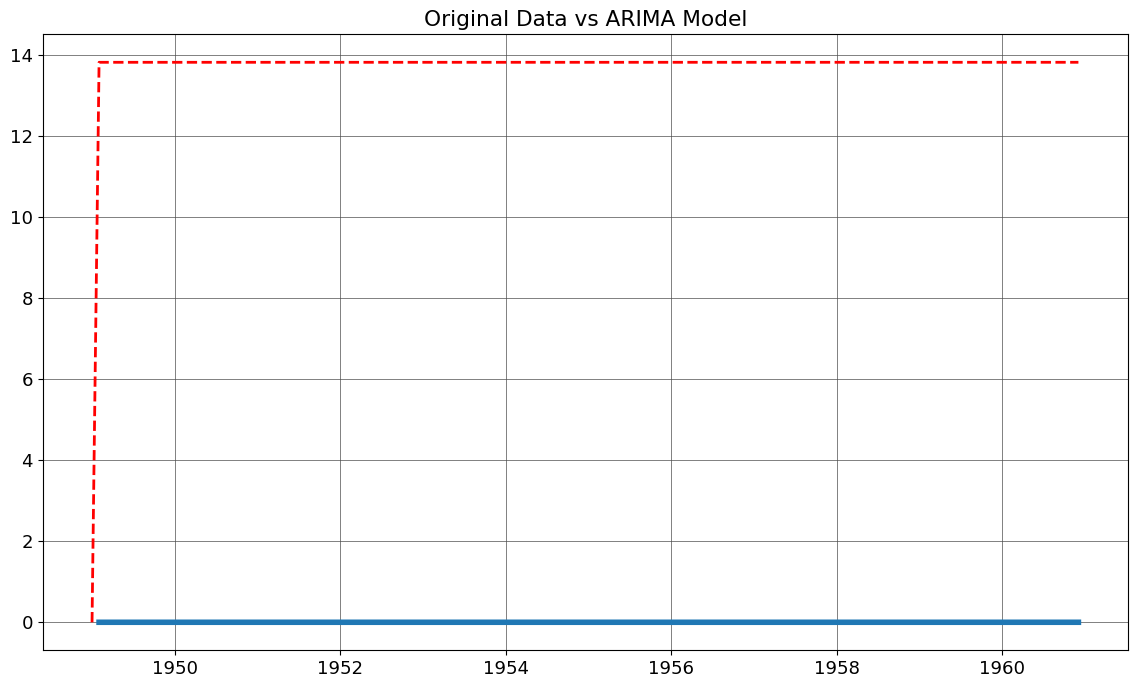

In [42]:
# Call figure() and plot() on the plt
plt.figure(figsize=(14,8))
plt.plot(y_log_diff, linewidth=4)
plt.plot(model_fit.predict(), color = 'red', linestyle='dashed')
plt.title('Original Data vs ARIMA Model')
plt.grid(True)

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

AttributeError: 'Series' object has no attribute 'append'

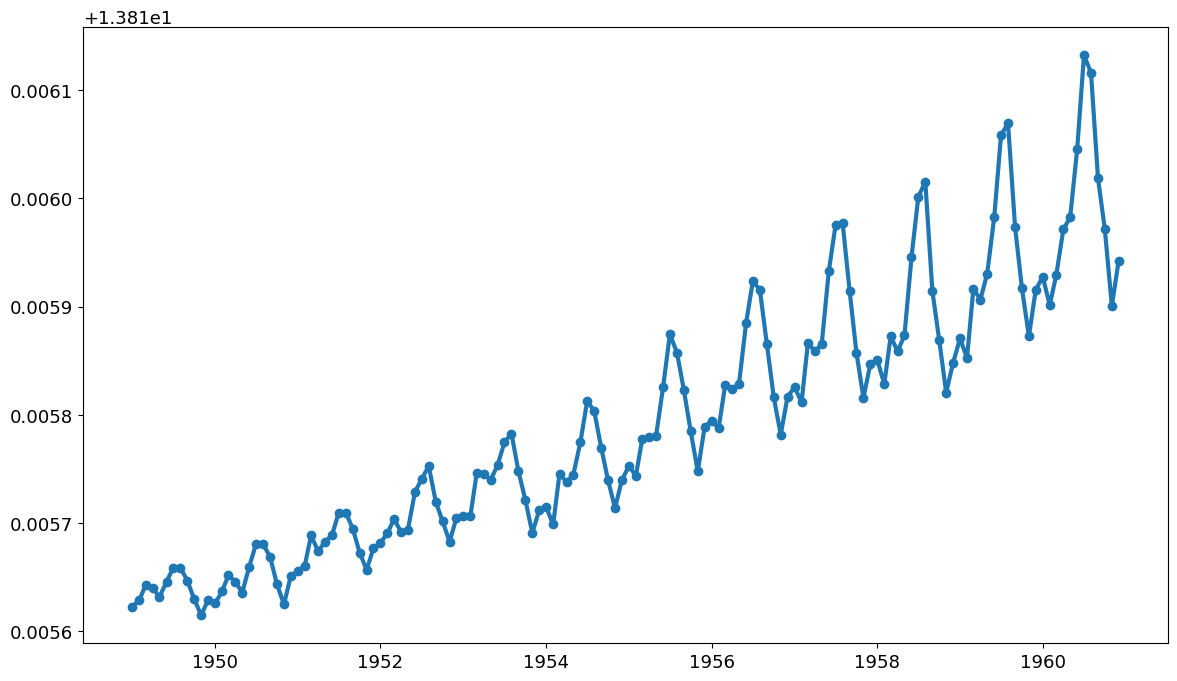

In [43]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(y_log.index[-1], periods=forecast_period,
                         freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])

# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace=True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(14,8))
plt.plot(y_log, linewidth=3, marker='o')
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']), linewidth=3, linestyle='dashed', color='r')
plt.grid(True)
plt.title('Original Data vs ARIMA Model: 24 Months Forecasting')
plt.show()

AttributeError: 'Series' object has no attribute 'append'

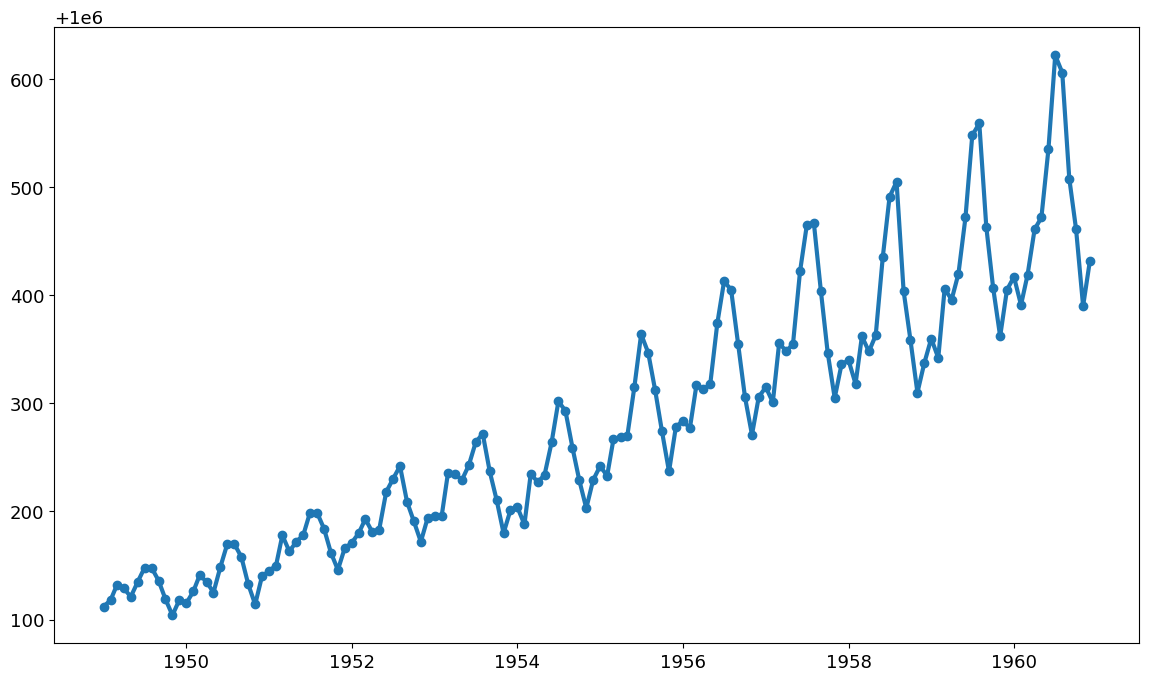

In [44]:
# Now plot the original variable y 
# Use the same functions as before
plt.figure(figsize=(14,8))
plt.plot(y, linewidth=3, marker='o')
plt.plot(np.exp(y_log['Nov 1960'].append(future_months['Prediction'])), linewidth=3, linestyle='dashed', color='r')
plt.grid(True)
plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          ['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])

plt.title('Original Data vs ARIMA Model: 24 Months Forecasting')
plt.xlabel('Month')
plt.ylabel('Cigarettes Sales')
plt.show()

From above chart we can see that ARIMA model was successfull in predicting/forecasting the trend of Cigarettes Sales, but missing the seasonality part which is obvious in Cigarettes Sales for the past years.

### So in order to capture both the trend and seasonality let's try SARIMA model ... coming NEXT !!!

 #### The Box-Jenkins method

Building time series models can represent a lot of work for the modeler and so we want to maximize our ability to carry out these projects fast, efficiently and rigorously. This is where the Box-Jenkins method comes in. The Box-Jenkins method is a kind of checklist for you to go from raw data to a model ready for production. The three main steps that stand between you and a production-ready model are identification, estimation and model diagnostics:

 1.  Identification:

 - Is a Time Series stationary?
 - What differencing will make it stationary?
 - What transforms will make it stationary?
 - What values of p and q are most promising?

 2.  Estimation:

 -  Estimate the AR and MA coefficients of the data by fitting the Model using .fit() method.
 -  At this stage we might fit many models and use the AIC and BIC to narrow down to more promising candidates

 3.  Model Diagnostics: 

 - Evaluate the quality of the fitting Model by using test statistics .summary() method and diagnostic plots .plot_diagnostics() method to make sure the residuals are well behaved!

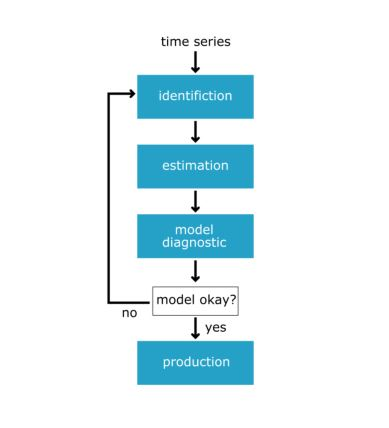

## The SARIMA model

#### # A SARIMA or seasonal ARIMA model is the tool of choice for seasonal time series. Fitting a SARIMA model is like fitting two different ARIMA models at once:

 - one to the seasonal part and
 - another to the non-seasonal part.
###### Since we have these two models we will have two sets of orders:

 - We have non-seasonal orders for the autoregressive, difference and moving average parts.
 - We also have this set of orders for the seasonal part.
 - We use capital P, D and Q for these seasonal orders.
  - There is also a new order, S, which is the length of the seasonal cycle.

#### Identification

Is a Time Series stationary? as shows previously y_log_diff is stationary let's plot the data and run a KPSS

Text(0.5, 1.0, 'Cigarettes Sales - log/diff')

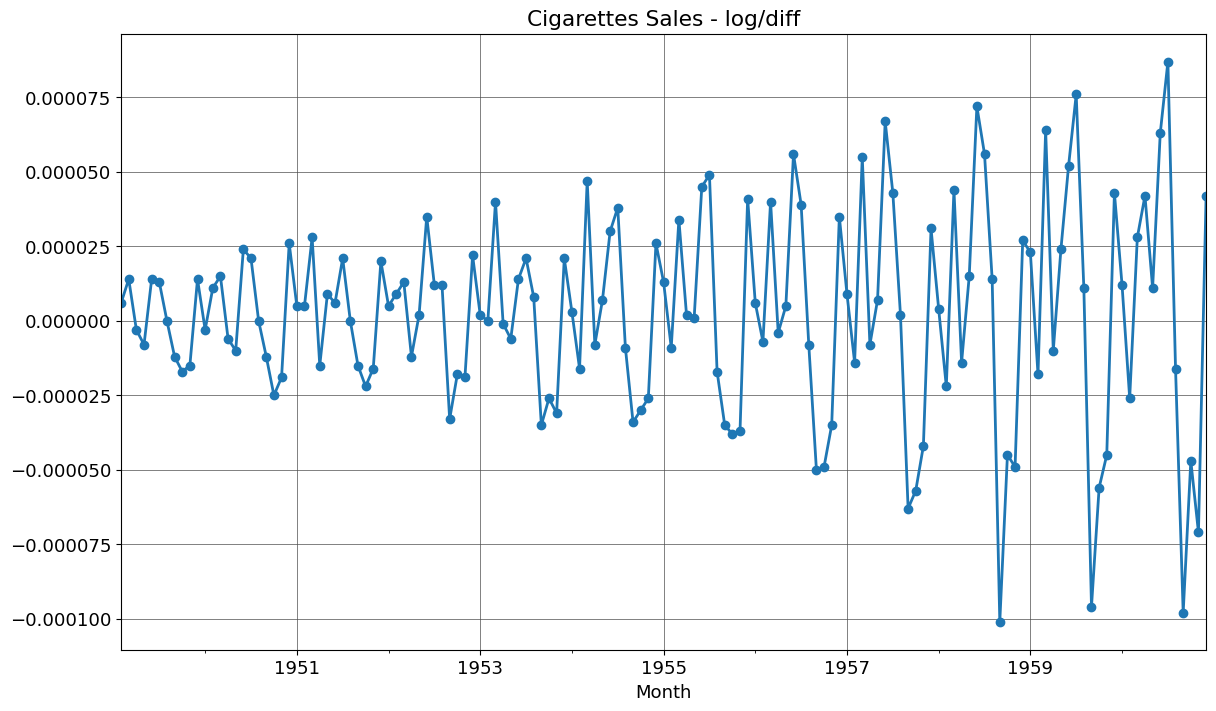

In [45]:
plt.figure(figsize=(14,8))
y_log_diff.plot(marker='o', linewidth=2)
#plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          #['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
#plt.ylim([1000100, 1000700])
plt.grid(True)
plt.title('Cigarettes Sales - log/diff')

##### Now let's Test for stationarity using KPSS

In [46]:
from statsmodels.tsa.stattools import kpss

print ('*******Results of kpss Test*******')
kpsstest = kpss(y_log_diff)
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)  
print ('**********************************')

*******Results of kpss Test*******
Test Statistic           0.023898
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
**********************************


 - Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

###### Now, let's check what values of (p,d,q)(P,D,Q)s are most promising?

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our SARIMA(p,d,q)(P,D,Q)s time series model:

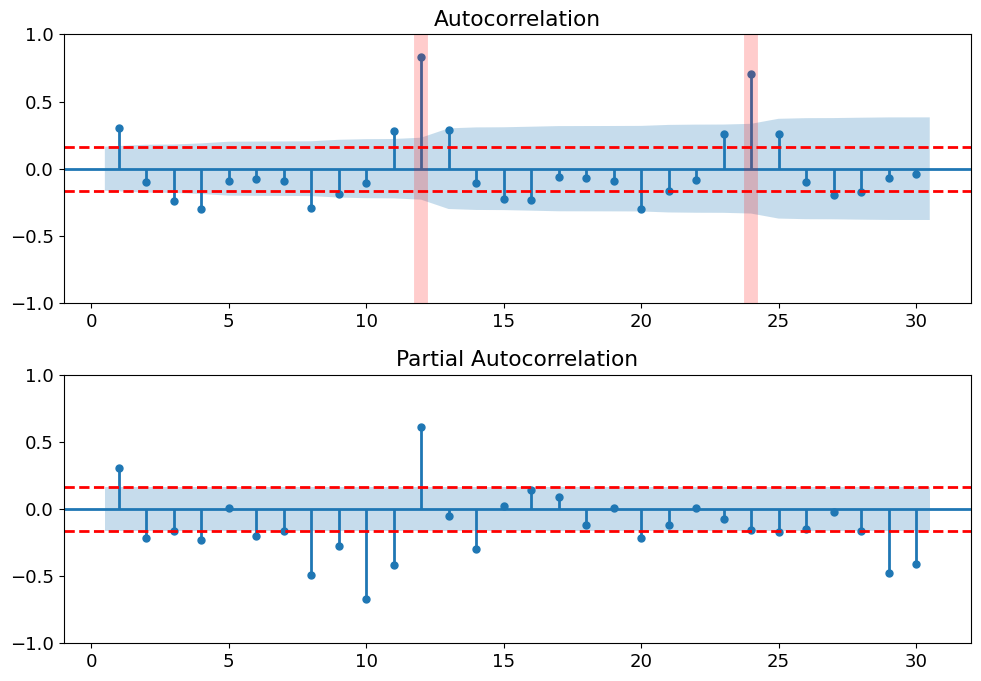

In [47]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7))
plot_acf(y_log_diff , zero=False, lags=30, ax=ax1)
ax1.axvline(12, color='red', ls='-', alpha=0.2, lw=10, label='lag = 12')
ax1.axvline(24, color='red', ls='-', alpha=0.2, lw=10, label='lag = 24')
ax1.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='red')
ax1.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='red')
plot_pacf(y_log_diff, zero=False, lags=30, ax=ax2)
ax2.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='red')
ax2.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='red')
plt.tight_layout()

n this plot, the two red dotted lines on either sides of 0 are representing the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:

 - q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.
 - p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1 or 2.
 - S - in SARIMA is 12 as shown from ACF plot

### Estimation

##### Parameter Selection for the SARIMA Time Series Model

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:

In [48]:
import itertools
p = range(1,3)
d = q = range(0, 2)
S = 12
pdq = list(itertools.product(p, d, q))
pdq = [(x[0],x[1], x[2]) for x in pdq]
seasonal_pdq = [(x[0], x[1],x[2],S) for x in pdq]

print(pdq)

[(1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1)]


In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

params = []
param_seasonals = []
aics = []
bics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,order=param,seasonal_order=param_seasonal)
            results = mod.fit()
            params.append(param)
            param_seasonals.append(param_seasonal)
            aics.append(results.aic)
            bics.append(results.bic)
        
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
df_aic_bic = pd.DataFrame([params, param_seasonals, aics, bics],index=['param', 'param_seasonal', 'aic', 'bic']).T
df_aic_bic.sort_values(by='aic', ascending=True).head(10)

,param,param_seasonal,aic,bic
5,"(1, 0, 0)","(2, 0, 1, 12)",10.0,24.849066
43,"(2, 0, 1)","(2, 0, 1, 12)",106.919743,127.708436
57,"(2, 1, 1)","(1, 1, 1, 12)",1022.256883,1039.508067
56,"(2, 1, 1)","(1, 1, 0, 12)",1023.24292,1037.618907
60,"(2, 1, 1)","(2, 1, 0, 12)",1024.835815,1042.086999
17,"(1, 1, 0)","(1, 1, 0, 12)",1025.294345,1033.919937
61,"(2, 1, 1)","(2, 1, 1, 12)",1025.835302,1045.961683
21,"(1, 1, 0)","(2, 1, 0, 12)",1026.799506,1038.300295
18,"(1, 1, 0)","(1, 1, 1, 12)",1026.983747,1038.484537
22,"(1, 1, 0)","(2, 1, 1, 12)",1027.230736,1041.606723


In [50]:
df_aic_bic.loc[(df_aic_bic.aic == df_aic_bic.aic.min()) | (df_aic_bic.bic == df_aic_bic.bic.min())]

,param,param_seasonal,aic,bic
5,"(1, 0, 0)","(2, 0, 1, 12)",10.0,24.849066


The output of our code suggests that SARIMAX(2, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 1022.26 (This confirmed what we predicted from the ACF and PACF). We should therefore consider this to be optimal option out of all the models we have considered.

#### Now let's fit our model using SARIMAX(2, 1, 1)x(1, 1, 1, 12):

In [53]:
#let's fit our model using (2, 1, 1)	(1, 1, 1, 12):
mod1 = SARIMAX(y,
              order=(2, 1, 1),
              seasonal_order=(1, 1, 1, 12), trend='t')
results1 = mod1.fit()

#### Model Diagnostics

In [54]:
print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           CigSales   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -505.360
Date:                            Sun, 02 Jun 2024   AIC                           1024.720
Time:                                    10:37:45   BIC                           1044.847
Sample:                                01-01-1949   HQIC                          1032.899
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.375      0.707      -0.001       0.002
ar.L1          0.6998      0.066   

#### Summary Statistics:
Some of these plots also have accompanying test statistics in results.summary() tables. Prob(Q) is the p-value associated with the null hypothesis that the residuals have no correlation structure. Prob(JB) is the p-value associated with the null hypothesis that the residuals are Guassian normally distributed. If either p-value is less than 0.05 we reject that hypothesis.

 - Prob(Q): p-value for null hypothesis that residuals are uncorrelated. Reject the null hypothesis and the residuals are correlated.
 - Prob(JB): p-value for null hypothesis that residuals are normally distributed. for our Model Prob(JB) is Zero , which means you should reject the null hypothesis that the residuals are normally distributed (This time the JB value was thrown off by the one outlying point in the time series).

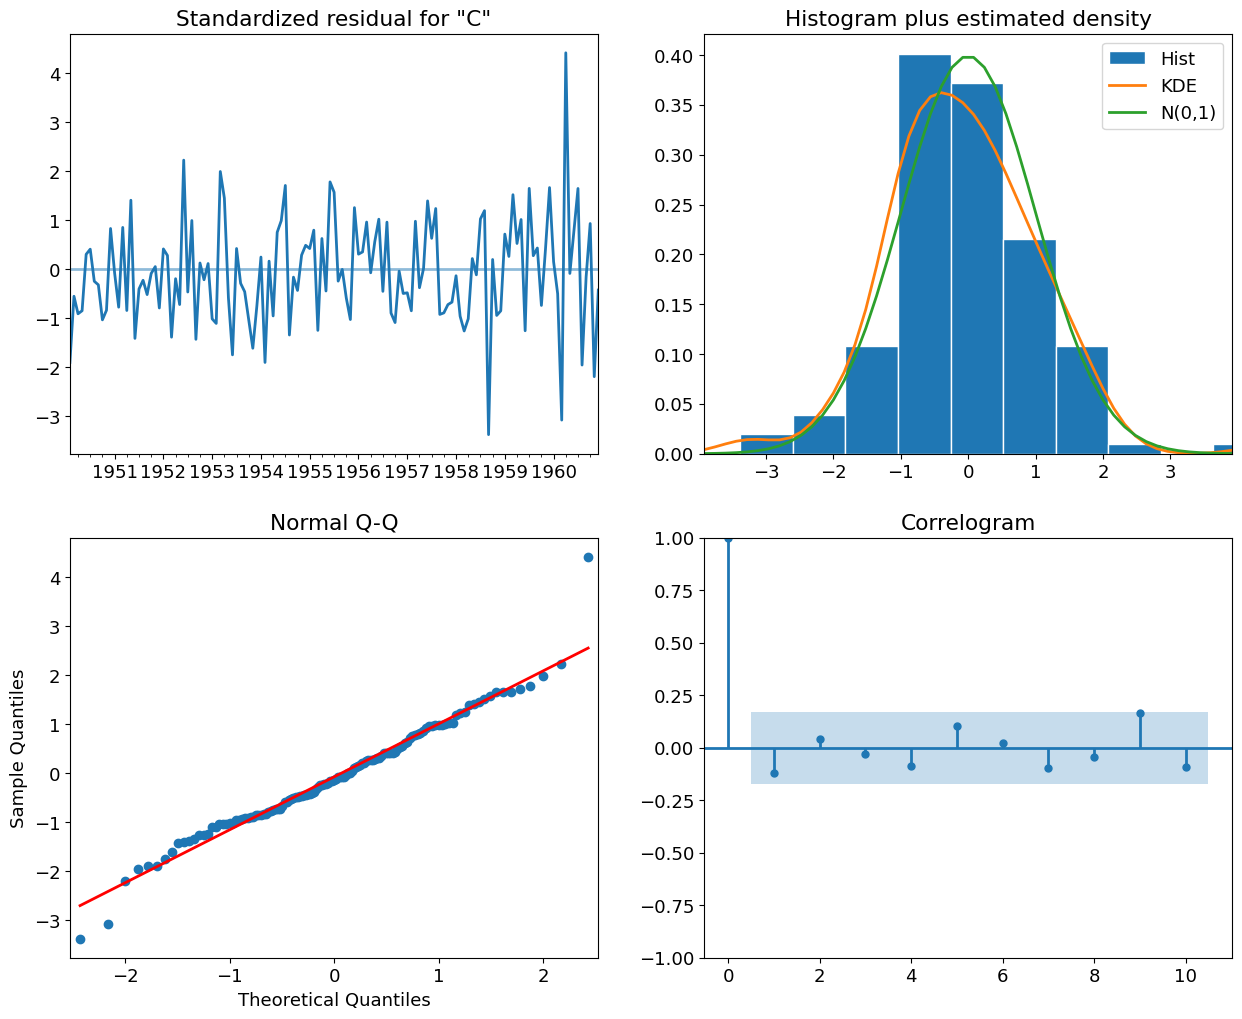

In [55]:
results1.plot_diagnostics(figsize=(15, 12))
plt.show()

From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise.

#### For an ideal model the residuals should be uncorrelated white Gaussian noise centered on zero. The rest of our diagnostics will help us to see if this is true:

 - Residuals plot: looks like our model is working correctly because there's no Obvious structure in the residuals.
 - Histogram plus estimated density: The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram; and the green line, shows a normal distribution. for our model looks fine ... these two lines are almost the same.
 - Normal Q-Q: Most of the data points should lie on the straight line (Residuals are normally distributed because most the points lie along the red line, except perhaps some values at either end).
 - Correlogram (ACF): 95% of correlations for lag greater than one should not be significant.

## Visualizing the Results:

In [56]:
pred = results1.get_prediction(start=pd.to_datetime('1951-01-01'), dynamic=False)
pred_ci = pred.conf_int()

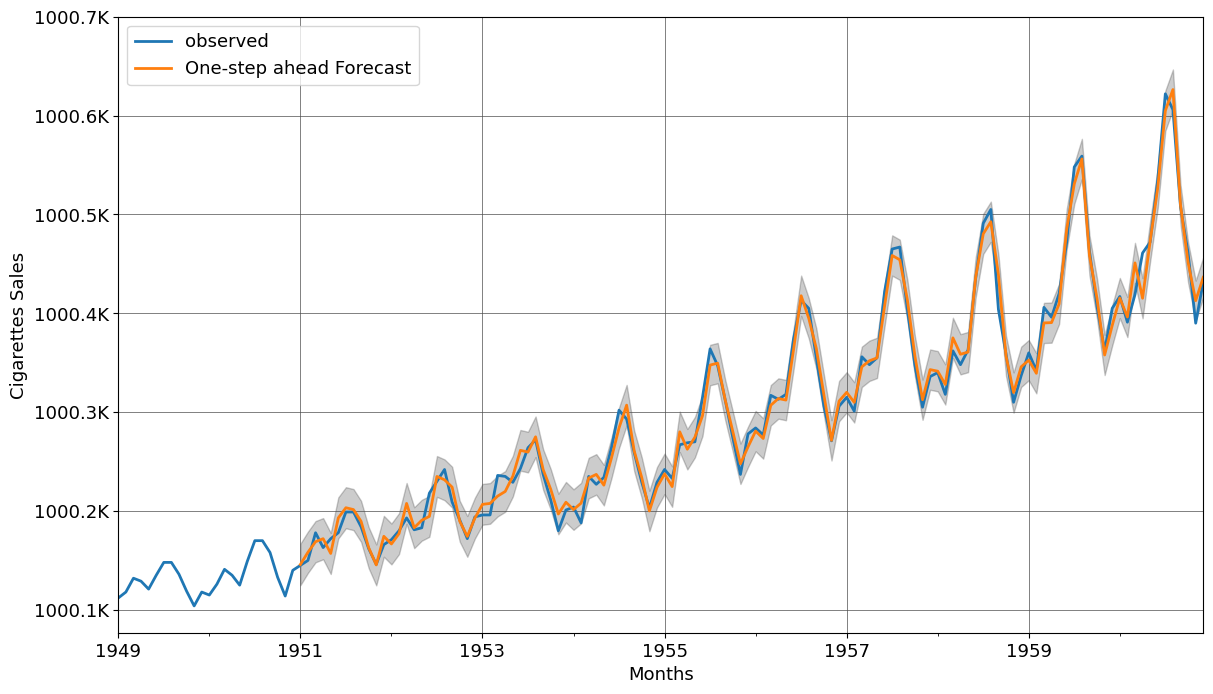

In [57]:
plt.figure(figsize=(14,8))
ax = y['1949':].plot(label='observed', linewidth=2)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', linewidth=2)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Months')
ax.set_ylabel('Cigarettes Sales')
plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          ['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [58]:
y_forecasted = pred.predicted_mean
y_truth = y['1951':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 132.33


### Application: Forecasting

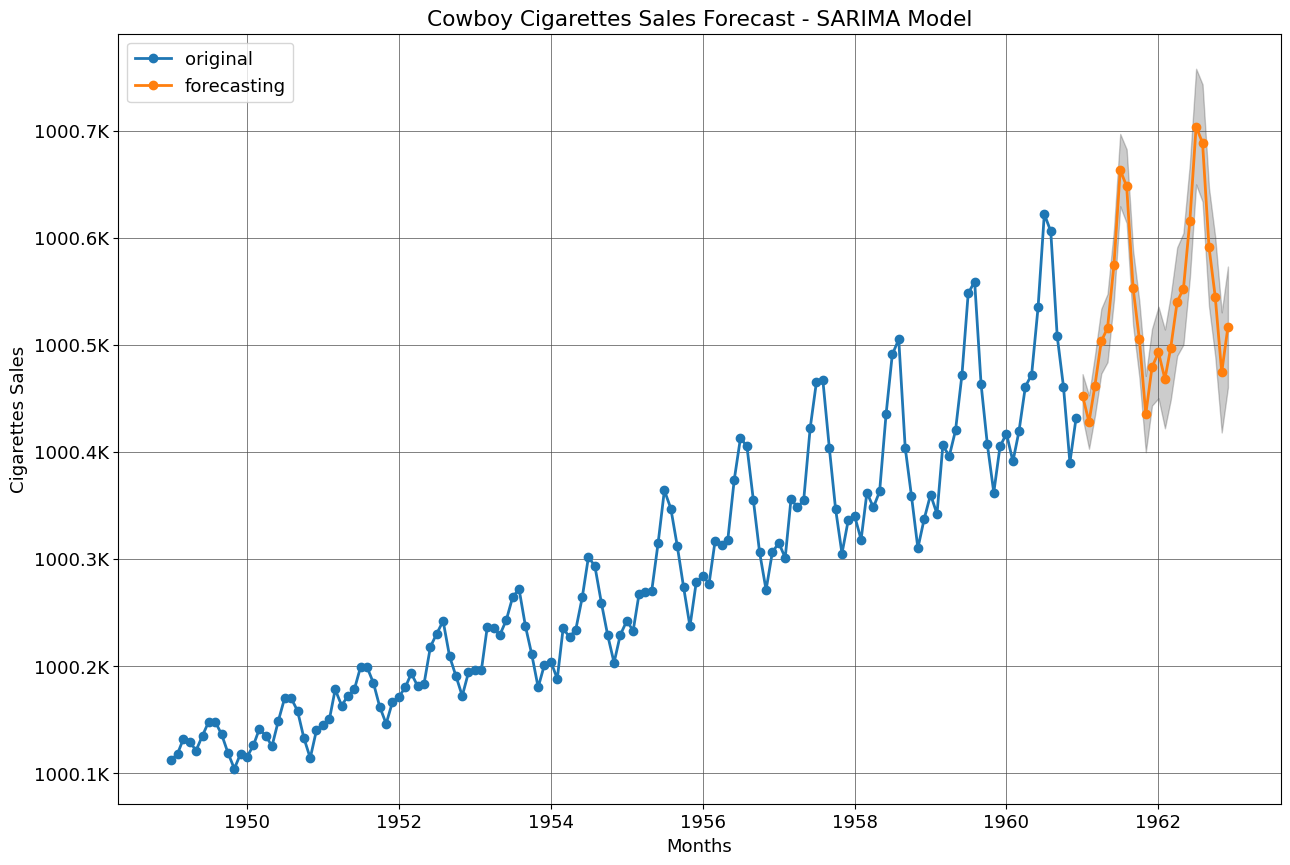

In [59]:
# forecast the futrue 24 month with the best model 
forecast = results1.forecast(24)
forecast_ci= results1.get_forecast(steps=24).conf_int()

forecast_period = 24

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y, label='original', marker='o', linewidth=2)
plt.plot(forecast, label = 'forecasting', marker='o', linewidth=2)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1]
                ,color='k', alpha=0.20)
plt.yticks([1000100, 1000200, 1000300, 1000400, 1000500, 1000600, 1000700],
          ['1000.1K', '1000.2K', '1000.3K', '1000.4K', '1000.5K', '1000.6K', '1000.7K'])
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Cowboy Cigarettes Sales Forecast - SARIMA Model')
plt.xlabel('Months')
plt.ylabel('Cigarettes Sales')
plt.show()

## 4. Evaluating and Concluding

Our models (ARIMA & SARIMA) managed to capture the center of a line and the seasonality that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors.

Remarkably, our ARIMA/SARIMA models made predictions using just one variable. We can only speculate, however, on the causes of the behavior predicted by our models.

### Conclusion:

Finaly, let's try answer the main question: whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining or staying the same:

In [60]:
# Create forecast object
forecast_object_fin = results1.get_forecast(steps=24)

# Extract predicted mean attribute
mean = forecast_object_fin.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object_fin.conf_int()

# Extract the forecast dates
dates = mean.index

In [61]:
# Print last predicted mean
print(mean.iloc[-1])

# Print last confidence interval
print(conf_int.iloc[-1])

1000516.637043707
lower CigSales    1.000460e+06
upper CigSales    1.000573e+06
Name: 1962-12-01 00:00:00, dtype: float64


##### Finaly, let's try answer the main question: whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining or staying the same:

 - From our SARIMA Model we estimate that Cowboy Cigarettes sales will keep increasing by roughly 20 from 1000500 to 1000570 (Upper)from January 1961 to December 1962.
 = Any increase in tobacco sales is a red flag since Smoking is the leading cause of preventable death. Worldwide, tobacco use causes more than 7 million deaths per year
 = For that reason, On June 22, 2009, President Barack Obama signed into law the Family Smoking Prevention and Tobacco Control Act, giving the U.S. Food and Drug Administration (FDA) comprehensive authority to regulate the manufacturing, marketing, and sale of tobacco products. The new law represents the most sweeping action taken to date to reduce what remains the leading preventable cause of death in the United States.
 = Before enactment of the new law, tobacco products were largely exempt from regulation under the nation’s federal health and safety laws, including the Food, Drug, and Cosmetic Act. The FDA has regulated food, drugs and cosmetics for many decades, but not tobacco products, except in those rare circumstances when manufacturers made explicit health claims.
 